<a href="https://colab.research.google.com/github/Dolphuwadol/Steamlit-time-series/blob/master/(LSTM)Prediction_Stock_Prices_on_the_SET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LSTM - Long short term memory

In [2]:
%%capture
#!pip install starfishX
#!pip install mplfinance

In [3]:
import pandas as pd
import numpy as np
import starfishX as sx
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook
%matplotlib inline

In [4]:
today = datetime.datetime.now().strftime('%Y-%m-%d')
symbol = 'KBANK'
df = sx.loadHistData_v2(symbol, start='1999-08-19', end=today)
df.reset_index(inplace=True)

ข้อมูลราคาย้อนหลังหุ้น KBANK ตั้งแต่วันที่ 04/01/2000 จนถึงปัจจุบัน
* Date : ปี/เดือน/วัน
* Open : ราคาเปิด
* High : ราคาสูงสุด
* Low  : ราคาต่ำสุด
* Close : ราคาปิด
* Adj Close : ราคาที่หักทุกอย่างแล้วทั้งปันผล ฯลฯ ซึ่งจะใช้เป็นราคาดัชนีที่อ้างอิงผลการลงทุนได้
* Volume : ปริมาณการซื้อขาย


In [5]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,44.25,44.75,44.0,44.50,28.315281,10659200
1,2000-01-05,42.25,43.00,41.5,41.75,26.565466,16305600
2,2000-01-06,42.00,42.00,40.5,40.75,25.929174,8241300
3,2000-01-07,41.25,43.00,41.0,42.75,27.201769,6058600
4,2000-01-10,43.75,44.25,42.5,42.75,27.201769,7774300
...,...,...,...,...,...,...,...
5924,2023-11-13,131.50,132.00,130.5,131.50,131.500000,6976700
5925,2023-11-14,132.00,133.00,131.5,132.00,132.000000,8217500
5926,2023-11-15,133.00,133.00,132.0,132.00,132.000000,11937900
5927,2023-11-16,132.50,132.50,131.5,132.00,132.000000,3640200


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5929 entries, 0 to 5928
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5929 non-null   datetime64[ns]
 1   Open       5929 non-null   float64       
 2   High       5929 non-null   float64       
 3   Low        5929 non-null   float64       
 4   Close      5929 non-null   float64       
 5   Adj Close  5929 non-null   float64       
 6   Volume     5929 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 324.4 KB


In [7]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5929.000000,5929.000000,5929.000000,5929.000000,5929.000000,5.929000e+03
mean,112.741348,113.881860,111.497301,112.685487,91.317222,9.221500e+06
std,64.679522,65.177764,64.132021,64.656434,57.718132,9.374375e+06
min,14.000000,14.250000,13.750000,14.000000,8.908178,0.000000e+00
25%,56.000000,56.500000,55.000000,56.000000,36.331406,4.138800e+06
50%,114.000000,115.500000,112.000000,114.000000,88.592987,6.680600e+06
75%,171.000000,173.000000,170.000000,171.000000,142.440704,1.109250e+07
max,251.000000,252.000000,249.000000,250.000000,205.898529,1.726078e+08


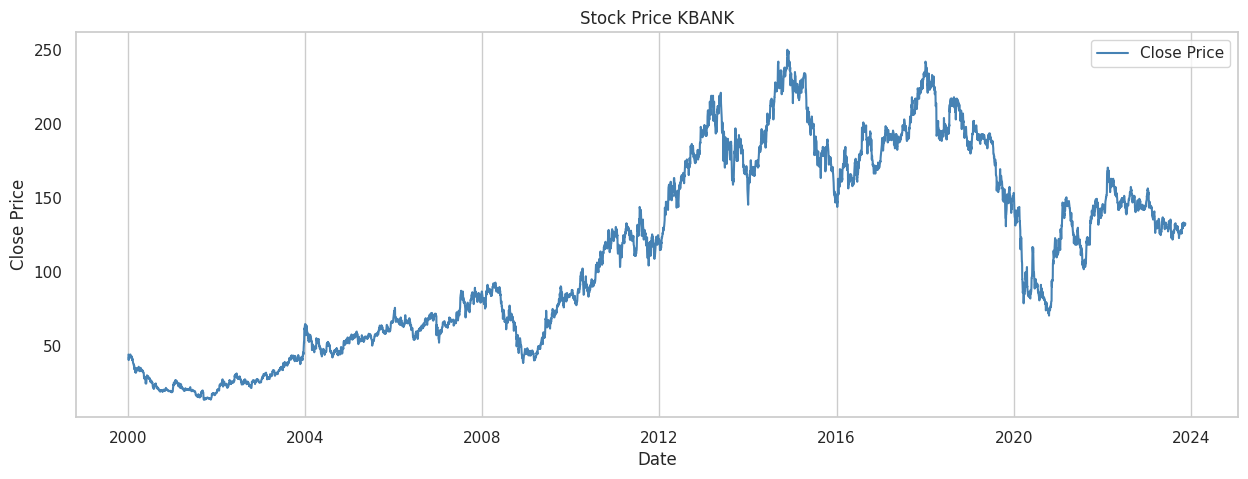

In [25]:
plt.figure(figsize=(15, 5))
plt.plot(df['Date'], df['Close'], label='Close Price', color='steelblue', linewidth=1.5)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price KBANK')
plt.grid(axis='y')
plt.legend()
plt.show()


Train test spilt

In [10]:
# สร้างตารางใหม่ที่ไม่มีคอลัมน์ 'Close'
data = df.filter(['Close'])
# Convert dataframe ให้เป็น numpy array
dataset = data.values
training_data_len = int(np.ceil(len(dataset) * .70))
training_data_len

4151

In [11]:
dataset

array([[ 44.5 ],
       [ 41.75],
       [ 40.75],
       ...,
       [132.  ],
       [132.  ],
       [133.  ]])

In [12]:
dataset.shape

(5929, 1)

Normalization
คอลัมน์ 'Volume' มีค่าที่โดดไปจากคอลัมน์อื่นๆเพื่อไม่ให้โมเดลมีการเอนเอียงเลยต้องทำการ Scale

In [13]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.12923729],
       [0.11758475],
       [0.11334746],
       ...,
       [0.5       ],
       [0.5       ],
       [0.50423729]])

In [14]:
# Train_set และ scale
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
      print(x_train)
      print(y_train)
      print()

# เปลี่ยน x_train และ y_train เป็น numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.12923729, 0.11758475, 0.11334746, 0.12182203, 0.12182203,
       0.11864407, 0.12076271, 0.11970339, 0.12394068, 0.125     ,
       0.12923729, 0.12923729, 0.12923729, 0.125     , 0.125     ,
       0.12288136, 0.12182203, 0.125     , 0.125     , 0.12182203,
       0.12182203, 0.11864407, 0.11334746, 0.11652542, 0.11758475,
       0.11440678, 0.11122881, 0.10805085, 0.10487288, 0.10275424,
       0.10275424, 0.10275424, 0.09745763, 0.09745763, 0.09745763,
       0.08686441, 0.09216102, 0.09004237, 0.09004237, 0.08474576,
       0.07838983, 0.08050847, 0.08686441, 0.08050847, 0.07733051,
       0.07838983, 0.08368644, 0.08368644, 0.08898305, 0.08580508,
       0.09004237, 0.08368644, 0.08580508, 0.08686441, 0.08686441,
       0.08686441, 0.08474576, 0.08474576, 0.08580508, 0.08898305])]
[0.09427966101694915]

[array([0.12923729, 0.11758475, 0.11334746, 0.12182203, 0.12182203,
       0.11864407, 0.12076271, 0.11970339, 0.12394068, 0.125     ,
       0.12923729, 0.12923729, 0.12

In [15]:
# สร้าง test_data และ scale
test_data = scaled_data[training_data_len - 60:, :]

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# เปลี่ยน x_test เป็น numpy arrays
x_test = np.array(x_test)

# Reshape data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [16]:
x_test

array([[[0.62711864],
        [0.6440678 ],
        [0.63983051],
        ...,
        [0.72033898],
        [0.76694915],
        [0.77754237]],

       [[0.6440678 ],
        [0.63983051],
        [0.63135593],
        ...,
        [0.76694915],
        [0.77754237],
        [0.76694915]],

       [[0.63983051],
        [0.63135593],
        [0.63135593],
        ...,
        [0.77754237],
        [0.76694915],
        [0.75      ]],

       ...,

       [[0.48728814],
        [0.49152542],
        [0.50211864],
        ...,
        [0.49788136],
        [0.49788136],
        [0.5       ]],

       [[0.49152542],
        [0.50211864],
        [0.49576271],
        ...,
        [0.49788136],
        [0.5       ],
        [0.5       ]],

       [[0.50211864],
        [0.49576271],
        [0.5       ],
        ...,
        [0.5       ],
        [0.5       ],
        [0.5       ]]])

LSTM - (Long Short-Term Memory)

In [17]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [18]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# สร้างโมเดล LSTM
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train โมเดล
History = model.fit(x_train, y_train, batch_size=5 , epochs=5, validation_split=0.2)

Epoch 1/5
655/655 [==============================] - 53s 74ms/step - loss: 7.7095e-04 - val_loss: 0.0018
Epoch 2/5
655/655 [==============================] - 50s 76ms/step - loss: 2.4741e-04 - val_loss: 6.7380e-04
Epoch 3/5
655/655 [==============================] - 46s 70ms/step - loss: 1.9601e-04 - val_loss: 7.2689e-04
Epoch 4/5
655/655 [==============================] - 47s 71ms/step - loss: 1.7318e-04 - val_loss: 3.6981e-04
Epoch 5/5
655/655 [==============================] - 47s 72ms/step - loss: 1.6476e-04 - val_loss: 3.0353e-04


In [19]:
# สร้าง test_data และ scale
test_data = scaled_data[training_data_len - 60:, :]

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# เปลี่ยน x_test เป็น numpy arrays
x_test = np.array(x_test)

# Reshape data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Predicton
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

56/56 [==============================] - 3s 37ms/step


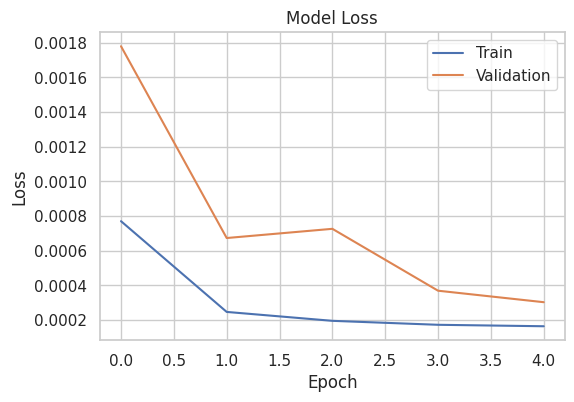

In [20]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))

sns.lineplot(data=History.history['loss'], label='Train')
sns.lineplot(data=History.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<ipython-input-21-2a3bdfc7b4f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


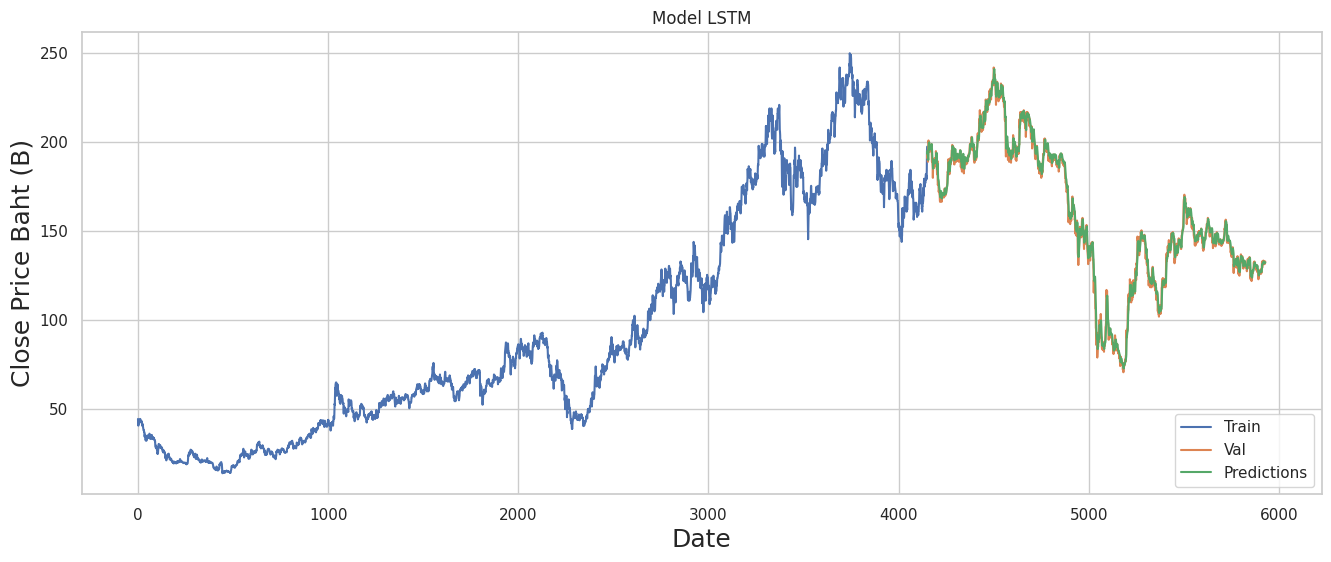

In [21]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 6))
plt.title('Model LSTM')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Baht (B)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [22]:
valid

,Close,Predictions
4151,195.0,193.516388
4152,191.0,195.177948
4153,193.0,193.525223
4154,189.0,192.777878
4155,190.5,190.710480
...,...,...
5924,131.5,132.129410
5925,132.0,132.004639
5926,132.0,132.175262
5927,132.0,132.350311


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [24]:
# Root mean squared error(RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) **2)))

# R2 Score
R2=   r2_score(y_test, predictions)

#Mean Squared Error(MSE)
mse = mean_squared_error(y_test, predictions)

#Mean Absolute Error(MAE)
mae = mean_absolute_error(y_test, predictions)

print(f'Root mean squared error (RMSE): {rmse}')
print(f'R-squared (R2):                 {R2}')
print(f'Mean Squared Error(MSE):        {mse}')
print(f'Mean absolute error (MAE):      {mae}')

Root mean squared error (RMSE): 3.185952711803998
R-squared (R2):                 0.9933745540449243
Mean Squared Error(MSE):        10.150294681851248
Mean absolute error (MAE):      2.3190292598694326
